In [2]:
import yfinance as yf
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix  
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

### 組建投資組合
0050：70%、0051：30% (暫時)
1. 設定初始投資金額為10萬

In [3]:
porfolio = pd.read_csv("porfolio.csv", encoding= "UTF-8")
TWII = pd.read_csv("台股大盤.csv", encoding= "UTF-8")
settlement = pd.read_csv("最後結算價.csv", encoding= "UTF-8")


# 使用 Date 欄位進行外部合併（保留所有日期）
df = pd.merge(porfolio, TWII, on='Date', how='outer')

# 如果你希望依照日期排序（建議這樣做）
df = df.sort_values(by='Date').reset_index(drop=True)
# 先依日期排序
df = df.sort_values(by="Date").reset_index(drop=True)

# 再用前一筆數據填補缺值
df["^TWII"] = df["^TWII"].fillna(method='ffill')
df

C:\Users\Joker Jeff\AppData\Local\Temp\ipykernel_28436\3744041466.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["^TWII"] = df["^TWII"].fillna(method='ffill')


,Date,0050.TW,0051.TW,^TWII
0,2015/1/12,48.054283,21.405308,9178.257813
1,2015/1/13,48.200447,21.636795,9231.757813
2,2015/1/14,47.944641,21.651262,9180.188477
3,2015/1/15,48.090828,21.542757,9165.047852
4,2015/1/16,47.871567,21.347437,9138.248047
...,...,...,...,...
2529,2025/5/5,171.949997,69.699997,20532.990230
2530,2025/5/6,171.000000,69.949997,20522.589840
2531,2025/5/7,170.350006,69.500000,20546.490230
2532,2025/5/8,172.600006,70.099998,20543.400390


In [4]:
# Step 0: 日期排序
df = df.sort_values(by="Date").reset_index(drop=True)

# Step 1: 計算 ETF 每日報酬率
df["0050_ret"] = df["0050.TW"].pct_change()
df["0051_ret"] = df["0051.TW"].pct_change()

# Step 2: 根據權重合併為投資組合的每日報酬率
weight_0050 = 0.70
weight_0051 = 0.30
df["portfolio_ret"] = weight_0050 * df["0050_ret"] + weight_0051 * df["0051_ret"]

# Step 3: 計算 ^TWII 每日報酬率
df["twii_ret"] = df["^TWII"].pct_change()

# Step 4: 累積報酬與資產變化
initial_capital = 100000
df["portfolio_cum_return"] = (1 + df["portfolio_ret"]).cumprod()
df["twii_cum_return"] = (1 + df["twii_ret"]).cumprod()

df["portfolio_value"] = initial_capital * df["portfolio_cum_return"]
df["twii_value"] = initial_capital * df["twii_cum_return"]

# Step 5: 計算統計指標
def calc_stats(ret_series, value_series):
    average_daily_return = ret_series.mean()
    std_daily_return = ret_series.std()
    annualized_return = (1 + average_daily_return) ** 252 - 1
    annualized_volatility = std_daily_return * np.sqrt(252)
    sharpe_ratio = (annualized_return - 0.01) / annualized_volatility
    max_drawdown = ((value_series - value_series.cummax()) / value_series.cummax()).min()
    final_value = value_series.iloc[-1]
    
    return {
        "年化報酬率": f"{annualized_return:.2%}",
        "年化波動度": f"{annualized_volatility:.2%}",
        "夏普比率": f"{sharpe_ratio:.2f}",
        "最大跌幅": f"{max_drawdown:.2%}",
        "期末資產價值": f"${final_value:,.2f}"
    }

# Step 6: 計算兩種策略績效
portfolio_results = calc_stats(df["portfolio_ret"].dropna(), df["portfolio_value"].dropna())
twii_results = calc_stats(df["twii_ret"].dropna(), df["twii_value"].dropna())

# Step 7: 組合結果成表格
summary_df = pd.DataFrame({
    "投資組合績效": portfolio_results,
    "^TWII績效": twii_results
})

summary_df


,投資組合績效,^TWII績效
年化報酬率,27.52%,19.04%
年化波動度,46.51%,43.12%
夏普比率,0.57,0.42
最大跌幅,-44.56%,-41.07%
期末資產價值,"$392,517.82","$227,875.92"


### 指標判斷機制

1. 用前60天的資料（例如 t-60 到 t-1）來預測 t 當天是否為極端事件
2. 六個指標共同觀察

In [5]:
# 使用 shift(1) 版本重建所有因子，確保只使用歷史資料，不洩漏未來資訊

window = 60
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)

# 建立目標變數
df["extreme_event"] = (df["portfolio_ret"] < -0.03).astype(int)

# 正確建構全部特徵（均使用 shift(1)）
df["mu_rolling"] = df["portfolio_ret"].rolling(window).mean().shift(1)
df["std_rolling"] = df["portfolio_ret"].rolling(window).std().shift(1)

df["rate_func"] = ((df["portfolio_ret"] - df["mu_rolling"])**2) / (2 * (df["std_rolling"]**2 + 1e-6))
df["z_score"] = (df["portfolio_ret"] - df["mu_rolling"]) / (df["std_rolling"] + 1e-6)
df["rolling_skew"] = df["portfolio_ret"].rolling(window).skew().shift(1)
df["rolling_kurt"] = df["portfolio_ret"].rolling(window).kurt().shift(1)
df["abs_momentum"] = df["portfolio_ret"].rolling(window).mean().abs().shift(1)
df["VaR_5"] = df["portfolio_ret"].rolling(window).quantile(0.05).shift(1)

# 整理乾淨的資料表格
feature_cols = ["Date", "portfolio_ret", "extreme_event", "rate_func", "z_score", "rolling_skew", "rolling_kurt", "abs_momentum", "VaR_5"]
df_factors = df[feature_cols].dropna().reset_index(drop=True)


In [6]:
df_factors

,Date,portfolio_ret,extreme_event,rate_func,z_score,rolling_skew,rolling_kurt,abs_momentum,VaR_5
0,2015-04-20,-0.007421,0,0.169698,-0.583637,4.576759,29.632363,0.002087,-0.014330
1,2015-04-21,-0.000299,0,0.008817,-0.133033,4.580183,29.569745,0.001874,-0.014330
2,2015-04-22,0.008503,0,0.080907,0.402990,4.581292,29.607149,0.001927,-0.014330
3,2015-04-23,0.022365,0,0.769581,1.242876,4.539847,29.282715,0.002058,-0.014330
4,2015-04-24,0.007343,0,0.042347,0.291539,4.344516,27.448959,0.002530,-0.014330
...,...,...,...,...,...,...,...,...,...
2463,2025-05-23,-0.003304,0,0.001058,-0.046014,1.784514,9.649203,0.001246,-0.058717
2464,2025-05-26,-0.000774,0,0.000044,0.009413,1.781490,9.645289,0.001195,-0.058717
2465,2025-05-27,-0.008059,0,0.012370,-0.157326,1.772203,9.637140,0.001028,-0.058717
2466,2025-05-28,0.000757,0,0.000996,0.044648,1.786334,9.669532,0.001238,-0.058717


### 回歸模型建構


In [7]:
# --- 1. 準備資料 -------------------------------------------------
df_factors["Date"] = pd.to_datetime(df_factors["Date"])

feature_cols = ["rate_func", "z_score", "rolling_skew",
                "rolling_kurt", "abs_momentum"]

train_df = df_factors[df_factors["Date"].dt.year <= 2019]
test_df  = df_factors[df_factors["Date"].dt.year >= 2020]

X_train, y_train = train_df[feature_cols], train_df["extreme_event"]
X_test,  y_test  = test_df[feature_cols],  test_df["extreme_event"]

# --- 2. 訓練邏輯回歸模型 -----------------------------------------
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

# --- 3. 基本評估：分類報告 + AUC -------------------------------
y_pred     = logreg.predict(X_test)
y_prob     = logreg.predict_proba(X_test)[:, 1]

report = classification_report(y_test, y_pred, digits=4)   
auc    = roc_auc_score(y_test, y_prob)                      

# --- 4. 係數重要性 ----------------------------------------------
coef_df = (pd.DataFrame({"Feature": feature_cols,
                         "Coefficient": logreg.coef_[0]})
           .assign(AbsCoef = lambda d: d["Coefficient"].abs())
           .sort_values("AbsCoef", ascending=False))

# --- 5. permutation importance ----------------------------------
perm = permutation_importance(
    logreg, X_test, y_test,
    n_repeats=30, random_state=42, scoring="f1"
)
perm_df = (pd.DataFrame({"Feature": feature_cols,
                         "PermImportance": perm.importances_mean})
           .sort_values("PermImportance", ascending=False))


### 回歸模型表現與預測績效觀察


#### 1. 回歸模型與各指標表現
全部都呈現顯著性

In [9]:
y = df_factors["extreme_event"]
X = df_factors[feature_cols]
logit_model = sm.Logit(y, X)
result = logit_model.fit()

print(result.summary())


Optimization terminated successfully.
         Current function value: 0.236818
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:          extreme_event   No. Observations:                 2468
Model:                          Logit   Df Residuals:                     2463
Method:                           MLE   Df Model:                            4
Date:                Fri, 13 Jun 2025   Pseudo R-squ.:                -0.08136
Time:                        14:51:19   Log-Likelihood:                -584.47
converged:                       True   LL-Null:                       -540.49
Covariance Type:            nonrobust   LLR p-value:                     1.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
rate_func        0.1956      0.024      8.109      0.000       0.148       0.243
z_score         -1.8132

#### 觀察特徵重要性
發現z_score是最重要的，與其他幾個指標有落差

In [10]:
importance_df = (coef_df
                 .merge(perm_df, on="Feature")
                 .sort_values("AbsCoef", ascending=False)
                 .reset_index(drop=True))

print("=== Feature Importance ===")
print(importance_df)

=== Feature Importance ===
        Feature  Coefficient   AbsCoef  PermImportance
0       z_score    -3.651891  3.651891        0.603923
1     rate_func    -0.182684  0.182684        0.006870
2  rolling_skew    -0.088368  0.088368        0.028422
3  rolling_kurt     0.051325  0.051325        0.031731
4  abs_momentum     0.003118  0.003118        0.000000


#### 觀察是否存在共線性
觀察六個指標都不具有共線性

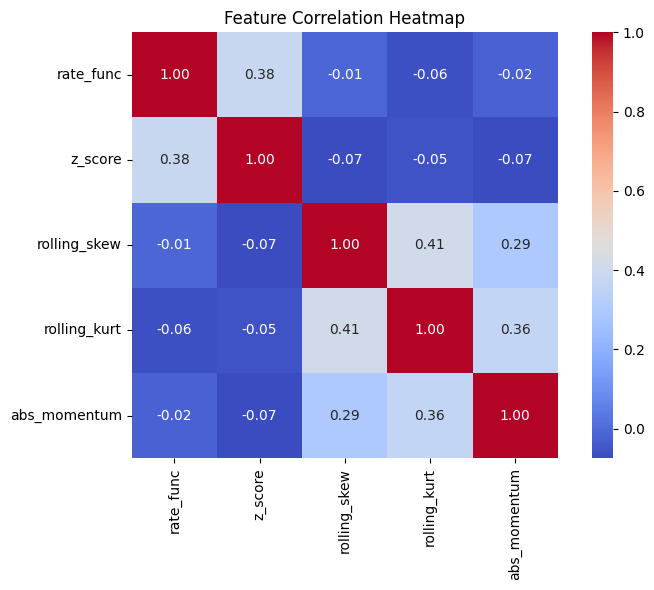


VIF 結果：
        Feature       VIF
0         const  3.160271
1     rate_func  1.172839
2       z_score  1.177621
3  rolling_skew  1.245404
4  rolling_kurt  1.314500
5  abs_momentum  1.188743

設計矩陣的秩：6
特徵數（含常數項）：6
是否滿秩？ 是 ✅


In [11]:
# 熱力圖可視化特徵間相關性
plt.figure(figsize=(8, 6))
corr_matrix = X.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

# 加入常數項（intercept）以便進行 VIF 分析
X_const = sm.add_constant(X)

# 計算 VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
print("\nVIF 結果：")
print(vif_data)

# 矩陣秩檢查
matrix_rank = np.linalg.matrix_rank(X_const)
n_features = X_const.shape[1]
print(f"\n設計矩陣的秩：{matrix_rank}")
print(f"特徵數（含常數項）：{n_features}")
print(f"是否滿秩？ {'是 ✅' if matrix_rank == n_features else '否 ❌'}")


#### 觀察其預測能力

In [13]:
# 1. 先把實際標籤掛進 test_df
test_df = test_df.reset_index(drop=True)   # 保險起見重排索引
y_test   = y_test.reset_index(drop=True)

test_df["actual_event"] = y_test           # ← 這行補進去

# 2. 預測結果 (0/1) 也加進去
test_df["pred_event_logreg"] = y_pred

# 3. 判斷是否命中
test_df["correct_prediction"] = (
    test_df["pred_event_logreg"] == test_df["actual_event"]
).astype(int)

# 4. 計算整體命中率
accuracy = test_df["correct_prediction"].mean()
print(f"整體準確率：{accuracy:.2%}")


整體準確率：96.49%


In [14]:
test_df

,Date,portfolio_ret,extreme_event,rate_func,z_score,rolling_skew,rolling_kurt,abs_momentum,VaR_5,actual_event,pred_event_logreg,correct_prediction
0,2020-01-02,-0.000829,0,0.029691,-0.244078,-0.187715,4.335056,0.003389,-0.015541,0,0,1
1,2020-01-03,-0.006762,0,0.170397,-0.584718,-0.180204,4.320663,0.003347,-0.015541,0,0,1
2,2020-01-06,0.033672,0,1.559573,1.768954,-0.131815,4.276546,0.003053,-0.015541,0,0,1
3,2020-01-07,-0.005426,0,0.133551,-0.517615,-0.148656,3.824258,0.003735,-0.015541,0,0,1
4,2020-01-08,-0.003537,0,0.075917,-0.390263,-0.093339,3.900968,0.003347,-0.015541,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1305,2025-05-23,-0.003304,0,0.001058,-0.046014,1.784514,9.649203,0.001246,-0.058717,0,0,1
1306,2025-05-26,-0.000774,0,0.000044,0.009413,1.781490,9.645289,0.001195,-0.058717,0,0,1
1307,2025-05-27,-0.008059,0,0.012370,-0.157326,1.772203,9.637140,0.001028,-0.058717,0,0,1
1308,2025-05-28,0.000757,0,0.000996,0.044648,1.786334,9.669532,0.001238,-0.058717,0,0,1


預測風險分數與實際極端事件之時間序列對照觀察

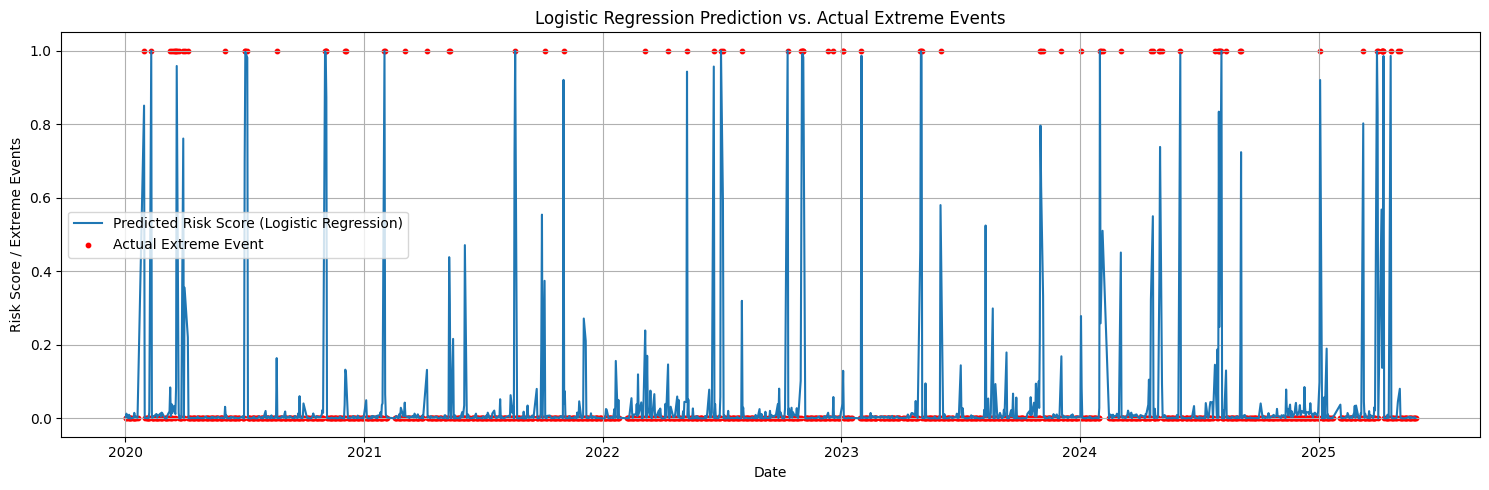

In [15]:
# 1. 重新取得「預測機率」並存入 test_df
test_df["FutureRiskScore_logreg"] = logreg.predict_proba(X_test)[:, 1] 

plt.figure(figsize=(15, 5))

# 折線：預測風險分數（邏輯回歸）
plt.plot(
    test_df["Date"],
    test_df["FutureRiskScore_logreg"],
    label="Predicted Risk Score (Logistic Regression)"
)

# 散點：實際極端事件
plt.scatter(
    test_df["Date"],
    test_df["actual_event"],
    color="red",
    label="Actual Extreme Event",
    s=10
)

plt.title("Logistic Regression Prediction vs. Actual Extreme Events")
plt.ylabel("Risk Score / Extreme Events")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
test_df["predicted_event_by_score"] = (test_df["FutureRiskScore_logreg"] >= 0.3).astype(int)
test_df["hit"] = (test_df["predicted_event_by_score"] == test_df["actual_event"]).astype(int)

precision = (test_df["hit"] & test_df["predicted_event_by_score"]).sum() / test_df["predicted_event_by_score"].sum()
recall = (test_df["hit"] & test_df["actual_event"]).sum() / test_df["actual_event"].sum()

print(f"命中率（Precision）: {precision:.2%}")
print(f"召回率（Recall）: {recall:.2%}")


命中率（Precision）: 93.10%
召回率（Recall）: 62.79%


In [17]:
# 1. 篩選實際有發生極端事件的日子
extreme_days = test_df[test_df["actual_event"] == 1].copy()

# 2. 加上模型是否預測成功的標記
extreme_days["hit"] = (extreme_days["pred_event_logreg"] == 1).astype(int)

# 3. 顯示錯失的日子（模型預測為0但實際為1）
missed_days = extreme_days[extreme_days["hit"] == 0]

# 4. 顯示總表（也可匯出檢查）
import pandas as pd
extreme_days[["Date", "FutureRiskScore_logreg", "pred_event_logreg", "actual_event", "hit"]]


,Date,FutureRiskScore_logreg,pred_event_logreg,actual_event,hit
13,2020-01-30,0.850661,1,1,1
20,2020-02-10,1.000000,1,1,1
40,2020-03-10,0.084051,0,1,0
42,2020-03-12,0.039072,0,1,0
44,2020-03-16,0.034114,0,1,0
...,...,...,...,...,...
1274,2025-04-09,0.411380,0,1,0
1275,2025-04-10,0.985607,1,1,1
1282,2025-04-21,0.985758,1,1,1
1290,2025-05-02,0.045029,0,1,0


觀察其預測之混淆矩陣與precision, recall, f1-score, support

In [18]:
# 檢查是否有必要欄位
required_columns = ["FutureRiskScore_logreg", "actual_event"]
assert all(col in test_df.columns for col in required_columns), "欄位缺失"

# 建立預測分類：若機率 > 0.3 則預測為極端事件（可調整門檻）
threshold = 0.3
test_df["predicted_event"] = (test_df["FutureRiskScore_logreg"] > threshold).astype(int)

# 混淆矩陣
conf_matrix = confusion_matrix(test_df["actual_event"], test_df["predicted_event"])
conf_matrix_df = pd.DataFrame(conf_matrix, 
                              index=["實際:正常日", "實際:極端日"], 
                              columns=["預測:正常日", "預測:極端日"])

# 分類報告
report = classification_report(test_df["actual_event"], test_df["predicted_event"], output_dict=True)
report_df = pd.DataFrame(report).transpose()

conf_matrix_df


,預測:正常日,預測:極端日
實際:正常日,1220,4
實際:極端日,32,54


In [19]:
report_df

,precision,recall,f1-score,support
0,0.974441,0.996732,0.985460,1224.000000
1,0.931034,0.627907,0.750000,86.000000
accuracy,0.972519,0.972519,0.972519,0.972519
macro avg,0.952738,0.812320,0.867730,1310.000000
weighted avg,0.971591,0.972519,0.970003,1310.000000
